In [50]:
from scapy.all import * # Packet manipulation
import pandas as pd # Pandas - Create and Manipulate DataFrames
import numpy as np # Math Stuff (don't worry only used for one line :] )
import binascii # Binary to Ascii
import seaborn as sns
sns.set(color_codes=True)
%matplotlib inline
import matplotlib.pyplot as plt

**Preámbulo**

In [51]:
# Capturando los primeros 25 paquetes de la red doméstica
captured_packets = sniff(count=25)

# Imprimiendo tipo de variable, longitud y contenido
print("Tipo de variable:", type(captured_packets))
print("Longitud de la variable:", len(captured_packets))
print("Contenido de la variable:", captured_packets)

# Imprimiendo el tipo de dato del primer paquete capturado
first_packet = captured_packets[0]
print("Tipo de dato del primer paquete capturado:", type(first_packet))

# Imprimiendo contenido de 5 paquetes
print("\nContenido de los primeros 5 paquetes capturados:")
for i in range(5):
    print("Paquete", i+1, ":", captured_packets[i].summary())

Tipo de variable: <class 'scapy.plist.PacketList'>
Longitud de la variable: 25
Contenido de la variable: <Sniffed: TCP:16 UDP:9 ICMP:0 Other:0>
Tipo de dato del primer paquete capturado: <class 'scapy.layers.l2.Ether'>

Contenido de los primeros 5 paquetes capturados:
Paquete 1 : Ether / IP / TCP 192.168.5.206:44761 > 206.247.31.102:https PA / Raw
Paquete 2 : Ether / IP / TCP 192.168.5.206:44828 > 23.223.28.214:https A / Raw
Paquete 3 : Ether / IP / TCP 206.247.31.102:https > 192.168.5.206:44761 PA / Raw
Paquete 4 : Ether / IP / TCP 192.168.5.206:44761 > 206.247.31.102:https A
Paquete 5 : Ether / IP / TCP 192.168.5.206:44828 > 23.223.28.214:https A / Raw


Análisis estadístico

In [52]:
paquete_pcap = rdpcap("packanalisys.pcap")

df = pd.DataFrame()

# Iterando sobre los paquetes en paquete_pcap
for i, packet in enumerate(paquete_pcap):
    
    # Obteniendo el tiempo del paquete
    tiempo = packet.time
    
    # Verificar si el paquete tiene la capa IP
    if IP in packet:
        # Si la capa IP existe, se accede a los campos 'src' y 'dst'
        src_address = packet[IP].src
        dst_address = packet[IP].dst
    else:
        src_address = None
        dst_address = None

    # Verificando si el paquete tiene la capa TCP o UDP
    if TCP in packet:
        # Si la capa TCP existe, se accede a los campos 'sport' y 'dport'
        src_port = packet[TCP].sport
        dst_port = packet[TCP].dport
    elif UDP in packet:
        # Si la capa UDP existe, se accede a los campos 'sport' y 'dport'
        src_port = packet[UDP].sport
        dst_port = packet[UDP].dport
    else:
        src_port = None
        dst_port = None
    
    # Verificando si el paquete tiene la capa Raw (payload)
    if Raw in packet:
        # Si la capa Raw existe, se accede al payload
        payload = len(packet[Raw].load)
    else:
        payload = 0

  # Añadiendo los campos al DataFrame
    df_temp = pd.DataFrame({'Time': [tiempo], 'Src Address': [src_address], 'Dst Address': [dst_address], 'Src Port': [src_port], 'Dst Port': [dst_port], 'Payload': [payload]})
    df = pd.concat([df, df_temp], ignore_index=True)

print(df.head())

                Time  Src Address  Dst Address  Src Port  Dst Port  Payload
0  1532199330.917674   10.1.10.53  84.54.22.33        53        53      905
1  1532199330.950107  84.54.22.33   10.1.10.53        53        53        0
2  1532199331.937777   10.1.10.53  84.54.22.33        53        53      919
3  1532199331.956635  84.54.22.33   10.1.10.53        53        53        0
4  1532199332.960504   10.1.10.53  84.54.22.33        53        53      956


**Estadísticas**

Inciso a. Muestre todas las IP origen

In [53]:
print("Todas las IP origen:")
print(df['Src Address'].unique())

Todas las IP origen:
['10.1.10.53' '84.54.22.33' '75.75.75.75']


Inciso b. Muestre todas las IP destino

In [54]:
print("\nTodas las IP destino:")
print(df['Dst Address'].unique())


Todas las IP destino:
['84.54.22.33' '10.1.10.53' '75.75.75.75']


Inciso c.

In [55]:
# c. ¿Cuál es la IP origen más frecuente?
src_ip_mas_frecuente = df['Src Address'].value_counts().idxmax()
print("\nLa IP origen más frecuente es:", src_ip_mas_frecuente)

# i. ¿A qué IP destino se comunica con más frecuencia?
dst_ip_mas_frecuente = df[df['Src Address'] == src_ip_mas_frecuente]['Dst Address'].value_counts().idxmax()
print("La IP destino con la que se comunica más frecuentemente es:", dst_ip_mas_frecuente)

# ii. ¿A que puerto destino se comunica? ¿Cuál es el propósito de este puerto?
dst_port_mas_frecuente = df[(df['Src Address'] == src_ip_mas_frecuente) & (df['Dst Address'] == dst_ip_mas_frecuente)]['Dst Port'].value_counts().idxmax()
print("El puerto destino con el que se comunica más frecuentemente es:", dst_port_mas_frecuente)
print("El propósito de este puerto puede variar dependiendo del protocolo y la aplicación que lo esté utilizando.")

# iii. ¿Desde que puertos origen se comunica?
src_ports = df[df['Src Address'] == src_ip_mas_frecuente]['Src Port'].unique()
print("\nLos puertos origen desde los que se comunica son:", src_ports)


La IP origen más frecuente es: 10.1.10.53
La IP destino con la que se comunica más frecuentemente es: 84.54.22.33
El puerto destino con el que se comunica más frecuentemente es: 53
El propósito de este puerto puede variar dependiendo del protocolo y la aplicación que lo esté utilizando.

Los puertos origen desde los que se comunica son: [   53 15812 23903]


**Inciso 6.**

In [56]:
df["Time"] = df["Time"].astype(float) # Convirtiendo el campo 'Time' a tipo float para evitar problemas de conversión.

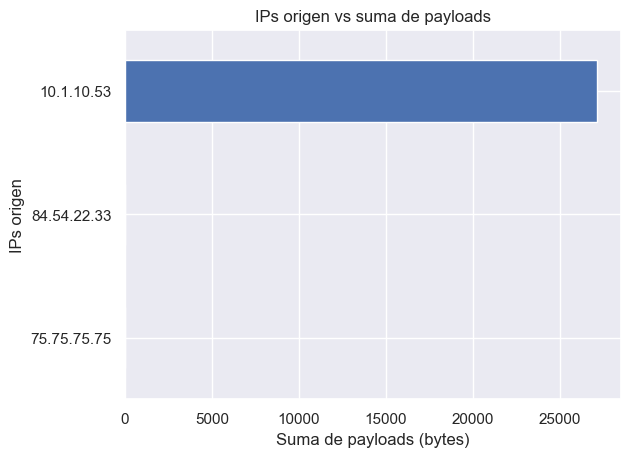

In [57]:
# a. Gráfica de barras 2D horizontales, IPs origen vs suma de payloads
df.groupby('Src Address')['Payload'].sum().sort_values().plot(kind='barh', title='IPs origen vs suma de payloads')
plt.xlabel('Suma de payloads (bytes)')
plt.ylabel('IPs origen')
plt.show()

Inciso b.

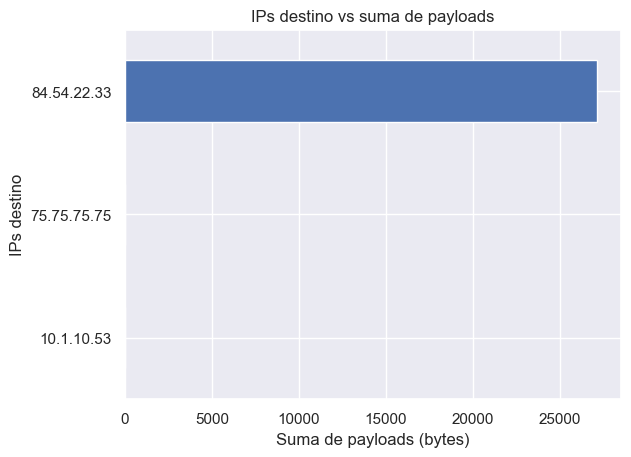

In [58]:
# b. Gráfica de barras 2D horizontales, IPs destino vs suma de payloads
df.groupby('Dst Address')['Payload'].sum().sort_values().plot(kind='barh', title='IPs destino vs suma de payloads')
plt.xlabel('Suma de payloads (bytes)')
plt.ylabel('IPs destino')
plt.show()

Inciso c.

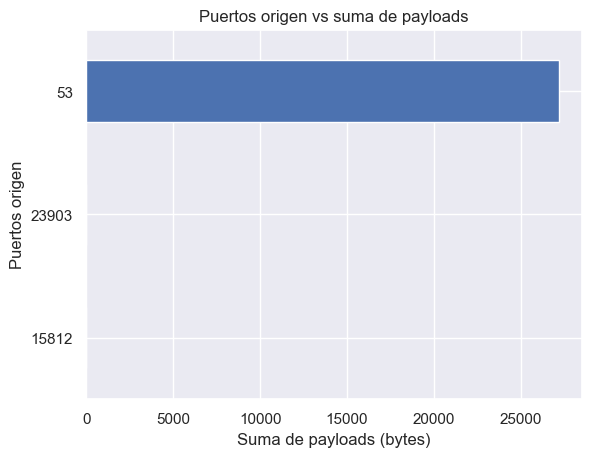

In [59]:
# c. Gráfica de barras 2D horizontales, puertos origen vs suma de payloads
df.groupby('Src Port')['Payload'].sum().sort_values().plot(kind='barh', title='Puertos origen vs suma de payloads')
plt.xlabel('Suma de payloads (bytes)')
plt.ylabel('Puertos origen')
plt.show()

Inciso d.

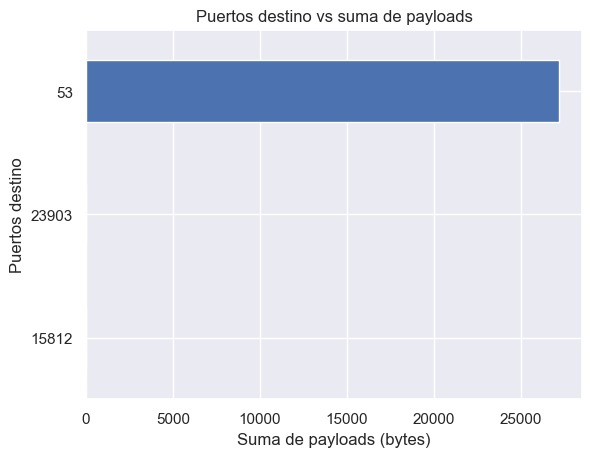

In [60]:
# d. Gráfica de barras 2D horizontales, puertos destino vs suma de payloads
df.groupby('Dst Port')['Payload'].sum().sort_values().plot(kind='barh', title='Puertos destino vs suma de payloads')
plt.xlabel('Suma de payloads (bytes)')
plt.ylabel('Puertos destino')
plt.show()

Inciso e.

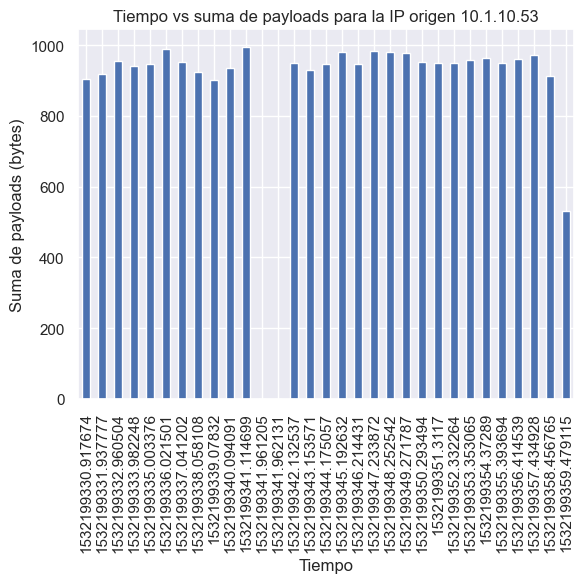

In [61]:
# e. Gráfica de barras 2D verticales, tiempo vs suma de payloads para la IP origen más frecuente
ip_mas_frecuente = df['Src Address'].value_counts().idxmax()
df[df['Src Address'] == ip_mas_frecuente].groupby('Time')['Payload'].sum().plot(kind='bar', title=f'Tiempo vs suma de payloads para la IP origen {ip_mas_frecuente}')
plt.xlabel('Tiempo')
plt.ylabel('Suma de payloads (bytes)')
plt.show()

inciso f. Utilizando la información de las estadísticas y la información del comportamiento del tráfico que las gráficas muestran, describa que es lo que está sucediendo.¿Es común el comportamiento?


Sí, es normal que las computadoras de la casa se estén comunicando con sitios web comunes como Google y YouTube. Además, están utilizando el puerto 53, que es el puerto DNS estándar empleado por el sistema operativo. Es importante señalar que la librería está detectando tanto los puertos de entrada como los de salida, y todos tienen direcciones coherentes.

**Inciso 7**

Inciso a.

In [64]:
# a. Creando un nuevo DataFrame que incluya únicamente las conexiones con la dirección IP origen más frecuente.
ip_mas_frecuente = df['Src Address'].value_counts().idxmax()
df_ip_mas_frecuente = df[df['Src Address'] == ip_mas_frecuente]

print(df_ip_mas_frecuente.head())

           Time Src Address  Dst Address  Src Port  Dst Port  Payload
0  1.532199e+09  10.1.10.53  84.54.22.33        53        53      905
2  1.532199e+09  10.1.10.53  84.54.22.33        53        53      919
4  1.532199e+09  10.1.10.53  84.54.22.33        53        53      956
6  1.532199e+09  10.1.10.53  84.54.22.33        53        53      942
8  1.532199e+09  10.1.10.53  84.54.22.33        53        53      947


Inciso b.

In [65]:
# b. Creando un nuevo DataFrame que utilice el DataFrame anterior con las columnas 'Src Address', 'Dst Address' y 'Payload' y agruparlas por 'Dst Address' y la suma del 'Payload'.
df_agrupado = df_ip_mas_frecuente.groupby('Dst Address')['Payload'].sum().reset_index()

print(df_agrupado)

   Dst Address  Payload
0  75.75.75.75        0
1  84.54.22.33    27167


Inciso c.

In [67]:
# c. Obteniendo la IP destino que más ha intercambiado bytes con la IP más frecuente.
ip_sospechosa = df_agrupado.sort_values('Payload', ascending=False)['Dst Address'].values[0]

print(ip_sospechosa)

84.54.22.33


Inciso d.

In [68]:
# d. Creando un nuevo DataFrame con la conversación entre la IP más frecuente y la IP sospechosa.
df_conversacion = df[(df['Src Address'] == ip_mas_frecuente) & (df['Dst Address'] == ip_sospechosa)]

print(df_conversacion.head())

           Time Src Address  Dst Address  Src Port  Dst Port  Payload
0  1.532199e+09  10.1.10.53  84.54.22.33        53        53      905
2  1.532199e+09  10.1.10.53  84.54.22.33        53        53      919
4  1.532199e+09  10.1.10.53  84.54.22.33        53        53      956
6  1.532199e+09  10.1.10.53  84.54.22.33        53        53      942
8  1.532199e+09  10.1.10.53  84.54.22.33        53        53      947


Inciso e.

In [70]:
# e. Obteniendo los payloads del DataFrame anterior, y añadir cada uno en un array.
array_payloads = df_conversacion['Payload'].values

print(array_payloads)

[905 919 956 942 947 989 952 923 903 936 995 950 930 948 981 948 983 981
 979 954 950 950 957 963 949 961 971 913 532]


Inciso g.

In [73]:
# g. Observar los primeros bytes del contenido.

# Convertir cada payload en una cadena de texto y mostrarla
for i, payload in enumerate(array_payloads):
    print(f"Payload {i+1}: {binascii.hexlify(df_conversacion.iloc[i]['Payload'])[:10]}")

Payload 1: b'8903000000'
Payload 2: b'9703000000'
Payload 3: b'bc03000000'
Payload 4: b'ae03000000'
Payload 5: b'b303000000'
Payload 6: b'dd03000000'
Payload 7: b'b803000000'
Payload 8: b'9b03000000'
Payload 9: b'8703000000'
Payload 10: b'a803000000'
Payload 11: b'e303000000'
Payload 12: b'b603000000'
Payload 13: b'a203000000'
Payload 14: b'b403000000'
Payload 15: b'd503000000'
Payload 16: b'b403000000'
Payload 17: b'd703000000'
Payload 18: b'd503000000'
Payload 19: b'd303000000'
Payload 20: b'ba03000000'
Payload 21: b'b603000000'
Payload 22: b'b603000000'
Payload 23: b'bd03000000'
Payload 24: b'c303000000'
Payload 25: b'b503000000'
Payload 26: b'c103000000'
Payload 27: b'cb03000000'
Payload 28: b'9103000000'
Payload 29: b'1402000000'



En este caso, se puede observar que el payload no parece ser sospechoso por varias razones. En primer lugar, la longitud del payload es relativamente normal, lo que no sugiere ninguna irregularidad. En mi opinión, este es un indicativo de que no hay ninguna actividad inusual o maliciosa.

Además, es de suma importancia mencionar que el contenido del payload aparenta ser coherente. No presenta substrings o subsecuencias aleatorias que podrían indicar la presencia de datos anómalos o un nivel de entropía excesivamente alto. Una alta entropía en los datos podría ser una señal de cifrado o de información oculta, lo cual no es el caso aquí.

Finalmente, se podría afirmar que los payloads son legítimos y correctos, ya que se deduce que provienen de conexiones con sitios web comunes y confiables como Google, YouTube, entre otros. Estos sitios son frecuentemente visitados y utilizados por los usuarios, lo que refuerza la normalidad del tráfico y de los payloads observados. En resumen, todo indica que la actividad observada no representa ningún riesgo o actividad sospechosa, y se puede concluir que el sistema está funcionando dentro de los parámetros esperados.